In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('churn.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
data.drop(columns = ['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# Эти колонки не понадобсятся нам для классификации

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.Gender.value_counts()

# Классы gender сбалансированы

Male      5457
Female    4543
Name: Gender, dtype: int64

In [ ]:
data.Geography.value_counts()

# В целом, дисбаланс классов geography не критичный

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [ ]:
data.Gender = LabelEncoder().fit_transform(data.Gender.values)
data = data.join(pd.get_dummies(data.Geography, prefix='geo')).drop(columns='Geography')
# Закодируем категориальные колонки

In [ ]:
data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,geo_France,geo_Germany,geo_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,1,0,0
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,0,1,0


In [ ]:
target = 'Exited'

In [ ]:
data.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,geo_France,geo_Germany,geo_Spain
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.501400,0.250900,0.247700
std,96.653299,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.500023,0.433553,0.431698
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.000000,0.000000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,1.000000,0.000000
max,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


## Baseline

In [ ]:
X, y = data.drop(columns=target), data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=42)
transformer = Normalizer().fit(X_train)

In [ ]:
%%time

X_train_trans = transformer.transform(X_train)
X_test_trans = transformer.transform(X_test)
clf = LogisticRegressionCV(solver='saga', cv=5, penalty='elasticnet', l1_ratios=[0, 0.5, 1])
clf.fit(X_train_trans, y_train)
preds = clf.predict(X_train_trans)
print(classification_report(preds, y_train))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      9000
           1       0.00      0.00      0.00         0

    accuracy                           0.80      9000
   macro avg       0.50      0.40      0.44      9000
weighted avg       1.00      0.80      0.89      9000

CPU times: user 12.1 s, sys: 1.6 s, total: 13.7 s
Wall time: 11.9 s


In [ ]:
print(classification_report(clf.predict(X_test_trans), y_test))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      1000
           1       0.00      0.00      0.00         0

    accuracy                           0.80      1000
   macro avg       0.50      0.40      0.44      1000
weighted avg       1.00      0.80      0.89      1000



В качестве baseline получили константную модель, сделаем sampling, чтобы улучшить её показатели

### up- and downsampling

In [ ]:
# upsampling
upsampling_size = (y_train.value_counts().values[0] - y_train.value_counts().values[1])

data_train = X_train.join(y_train)  
up_data_train = data_train[data_train[target] == 1].sample(upsampling_size, replace=True, random_state=42)
data_train = pd.concat([data_train, up_data_train])
data_train[target].value_counts()

1    7167
0    7167
Name: Exited, dtype: int64

In [ ]:
%%time
X_train_, y_train_ = data_train.drop(columns=target), data_train[target]
transformer = Normalizer().fit(X_train_)

X_train_trans = transformer.transform(X_train_)
X_test_trans = transformer.transform(X_test)
clf = LogisticRegressionCV(solver='saga', cv=5, penalty='elasticnet', l1_ratios=[0, 0.5, 1])
clf.fit(X_train_trans, y_train_)

CPU times: user 21.1 s, sys: 1.67 s, total: 22.8 s
Wall time: 20.9 s


In [ ]:
# реузультаты на тесте
print(classification_report(clf.predict(X_test_trans), y_test))

              precision    recall  f1-score   support

           0       0.40      0.85      0.54       371
           1       0.73      0.24      0.36       629

    accuracy                           0.46      1000
   macro avg       0.56      0.54      0.45      1000
weighted avg       0.60      0.46      0.42      1000



In [ ]:
# downsampling
downsampling_size = y_train.value_counts().values[1]

data_train = X_train.join(y_train)  
down_data_train = data_train[data_train[target] == 0].sample(downsampling_size, random_state=42)
data_train = pd.concat([data_train[data_train[target] == 1], down_data_train])
data_train[target].value_counts()

1    1833
0    1833
Name: Exited, dtype: int64

In [ ]:
%%time
X_train_, y_train_,  = data_train.drop(columns=target), data_train[target]
transformer = Normalizer().fit(X_train_)

X_train_trans = transformer.transform(X_train_)
X_test_trans = transformer.transform(X_test)
clf = LogisticRegressionCV(solver='saga', cv=5, penalty='elasticnet', l1_ratios=[0, 0.5, 1])
clf.fit(X_train_trans, y_train_)

              precision    recall  f1-score   support

           0       0.42      0.59      0.49      1286
           1       0.72      0.55      0.62      2380

    accuracy                           0.57      3666
   macro avg       0.57      0.57      0.56      3666
weighted avg       0.61      0.57      0.58      3666

CPU times: user 4.35 s, sys: 11.1 ms, total: 4.36 s
Wall time: 4.34 s


In [ ]:
# реузультаты на тесте
print(classification_report(clf.predict(X_test_trans), y_test))

              precision    recall  f1-score   support

           0       0.43      0.85      0.57       397
           1       0.72      0.24      0.36       603

    accuracy                           0.48      1000
   macro avg       0.57      0.55      0.47      1000
weighted avg       0.60      0.48      0.44      1000



У downsampling показатели немного лучше на обучающей выборке

Текущее значение f1 macro = 0.47

## Исследование признаков

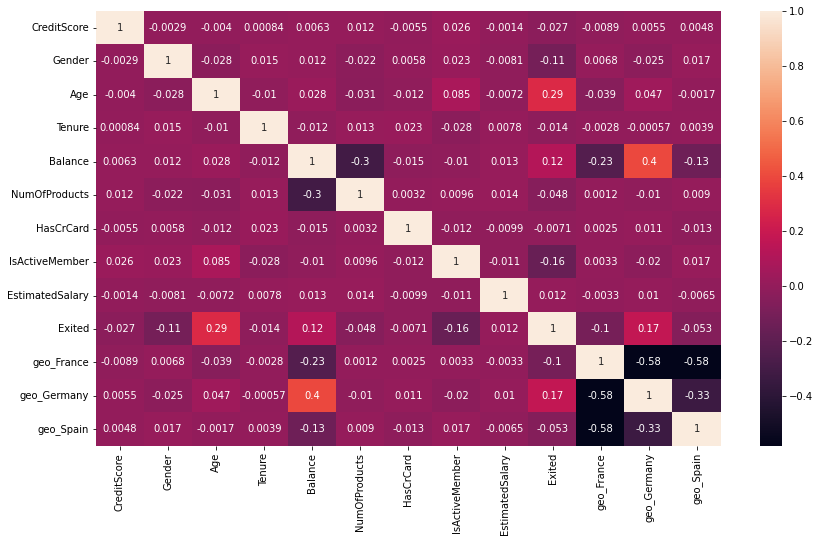

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(data.corr(), annot=True)

Из тепловой карты видно, что сильные корреляции отсутствуют, однако колонку geo_Germany можно удалить по следующим причинам:

1) Корреляция её с колонкой Balance небольшая, но всё же по порядку величины значительнее большинства остальных (выбирая по этому параметру оставили именно Balance, потому что кажется, что он больше решает, чем местоположжение)

2) Данная колонка получена с помощью ohe-кодирования, и хорошая практика брать n-1 полученных классов, т.к любое значение полученных колонок восстанавливается по значениям остальных

In [ ]:
# Используем для работы data_train

In [ ]:
%%time
X_train_, y_train_,  = data_train.drop(columns=[target, 'geo_Germany']), data_train[target]
transformer = Normalizer().fit(X_train_)

X_train_trans = transformer.transform(X_train_)
X_test_trans = transformer.transform(X_test.drop(columns='geo_Germany'))
clf = LogisticRegressionCV(solver='saga', cv=5, penalty='elasticnet', l1_ratios=[0, 0.5, 1])
clf.fit(X_train_trans, y_train_)
# реузультаты на тесте
print('test')
print(classification_report(clf.predict(X_test_trans), y_test))


test
              precision    recall  f1-score   support

           0       0.43      0.85      0.57       397
           1       0.72      0.24      0.36       603

    accuracy                           0.48      1000
   macro avg       0.57      0.55      0.47      1000
weighted avg       0.60      0.48      0.44      1000

CPU times: user 4.15 s, sys: 8.87 ms, total: 4.16 s
Wall time: 4.15 s


Результаты не изменились, но колонку мы всё же уберём

## Подберём наилучшие параметры для классификатора

In [ ]:
tuned_parameters = [
    {'solver': ['newton-cg', 'lbfgs', 'sag'],
     'penalty': ['l2'],
     'C': [0.01, 0.1, 1, 10, 100],
     'max_iter': [100, 500, 1000]
     },

    {'solver': ['liblinear', 'saga'],
     'penalty': ['l1', 'l2'],
     'C': [0.01, 0.1, 1, 10, 100],
     'max_iter': [100, 500, 1000]
     },
]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train_trans, y_train_)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_trans)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 100, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.86      0.43      0.57       796
           1       0.25      0.74      0.37       204

    accuracy                           0.49      1000
   macro avg       0.56      0.58      0.47      1000
weighted avg       0.74      0.49      0.53      1000




f1_macro для тестовой выборки по прежнему 0.47

Попробуем не нормализовывать выборку

In [ ]:
X_train_, y_train_,  = data_train.drop(columns=[target, 'geo_Germany']), data_train[target]


tuned_parameters = [
    {'solver': ['newton-cg', 'lbfgs', 'sag'],
     'penalty': ['l2'],
     'C': [0.01, 0.1, 1, 10, 100],
     'max_iter': [100, 500, 1000]
     },

    {'solver': ['liblinear', 'saga'],
     'penalty': ['l1', 'l2'],
     'C': [0.01, 0.1, 1, 10, 100],
     'max_iter': [100, 500, 1000]
     },
]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train_, y_train_)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test.drop(columns='geo_Germany'))
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       796
           1       0.39      0.70      0.50       204

    accuracy                           0.71      1000
   macro avg       0.65      0.71      0.65      1000
weighted avg       0.80      0.71      0.74      1000




Заключение

Для конечной модели (ограничиваясь логистической регрессией) лучшие результаты на тестовой выборке получились с использованием **downsamplnig**, **без нормализации** и с параметрами модели:

{'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}

f1_macro_best = 0.65